In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv("../transformed_data/X_train.csv")
y = pd.read_csv("../transformed_data/y_train.csv")

In [3]:
(X.isnull().sum() > 0).sum()

0

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, train_size=.8, random_state=42)
print(X_train.shape)
print(X_test.shape)

(7238, 192)
(1810, 192)


## GridSearch

In [6]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def cross_validate_calculate_scores(model, X, y):
    scores = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
    results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for score_name in scores:  
        score_results = cross_val_score(model, X, y, cv=skf, scoring=score_name)
        results.append(score_results)
    
    return results

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

def calculate_scores(X_train, X_test, y_train, y_test, model):
    
    val_scores = cross_validate_calculate_scores(model, X_test, y_test)
    
    sns.boxplot(data=val_scores)
    plt.title("Cross validation scores for " + str(model.__class__.__name__))
    plt.xticks([0, 1, 2, 3, 4], ['roc_auc', 'accuracy', 'precision', 'recall', 'f1'])
    
    
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    auc = roc_auc_score(y_test, y_predict)
    gini = 2 * auc - 1
    
    score_names = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1', 'gini']
    scores = [auc, accuracy, precision, recall, f1, gini]
    
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x= score_names, y=scores, color='palegreen')
    plt.title('Scores on test dataset for ' + str(model.__class__.__name__))
    
    for i, score in enumerate(scores):
        ax.text(i, score, f'{score:.2f}', ha='center', va='bottom')
        
    plt.show()    

In [8]:
from sklearn.model_selection import GridSearchCV
def optimize_params(model, params_grid, X_train, y_train):
    grid = GridSearchCV(estimator=model, param_grid=params_grid, scoring='recall', cv=5, n_jobs=-1)
    grid_results= grid.fit(X_train, y_train) 

    print("%s best recall_score: %f, using: %s" %(model.__class__.__name__, grid_results.best_score_, grid_results.best_params_))
    best_params = grid_results.best_params_

    if model.__class__.__name__ in ("LogisticRegression", "DecisionTreeClassifier", "GradientBoostingClassifier", "RandomForestClassifier", "SVC", "XGBClassifier"):
        model = model.__class__(random_state=42, **best_params)
    else:
        model = model.__class__(**best_params)
    
    return model

### LogisticRegression

In [62]:
y_train = np.ravel(y_train)

lg = LogisticRegression(random_state=42)

params_grid = {"C":np.logspace(-3,3,7), "penalty":["l2", "l1"], "solver": ["liblinear"]}

model1 = optimize_params(lg, params_grid, X_train, y_train)

LogisticRegression best recall_score: 0.963587, using: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}


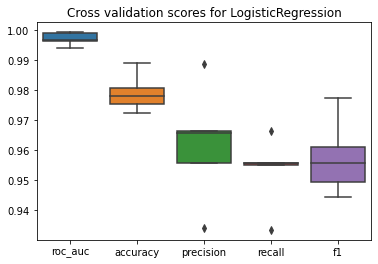

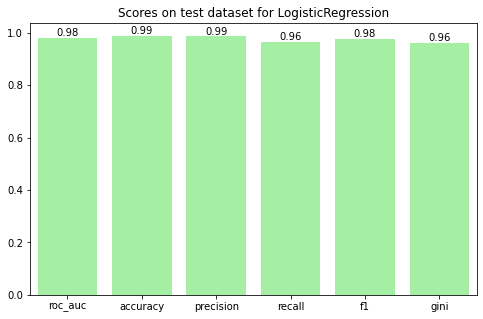

In [63]:
calculate_scores(X_train, X_test, y_train, y_test, model1)

### DecisionTreeClassifier

In [64]:
dtc = DecisionTreeClassifier(random_state=42)

params_grid = {"criterion": ["gini", "entropy"],
               "max_depth": np.arange(1, 11),
               "min_samples_leaf": np.arange(1, 6),
               "max_features": ["sqrt", "log2"],
               "ccp_alpha": [0, 0.05, 0.1]}

model2 = optimize_params(dtc, params_grid, X_train, y_train)

DecisionTreeClassifier best recall_score: 0.895109, using: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 3}


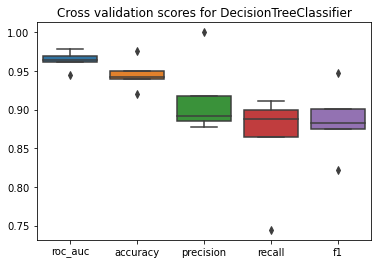

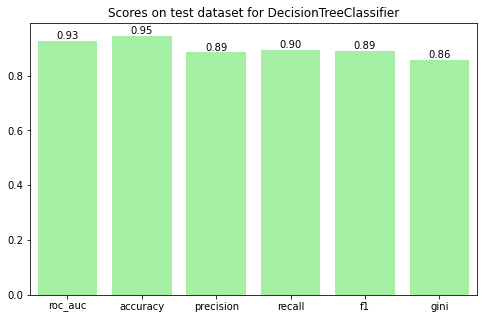

In [65]:
calculate_scores(X_train, X_test, y_train, y_test, model2)

### GaussianNB

In [66]:
gnb = GaussianNB()

params_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
model3 = optimize_params(gnb, params_grid, X_train, y_train)

GaussianNB best recall_score: 0.982065, using: {'var_smoothing': 2.310129700083158e-09}


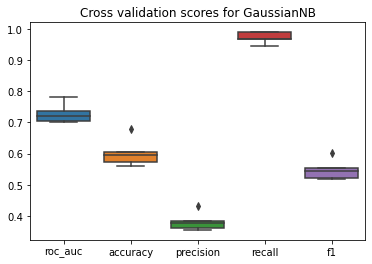

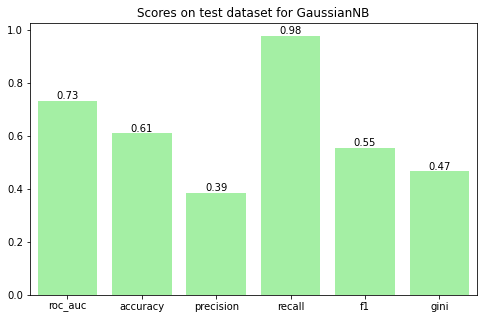

In [67]:
calculate_scores(X_train, X_test, y_train, y_test, model3)

### BernoulliNB

In [68]:
bnb = BernoulliNB()

params_grid = {"alpha": np.logspace(0,-9, num=100),
               "binarize": [1],
               "fit_prior": [False, True]}

model4 = optimize_params(bnb, params_grid, X_train, y_train)

BernoulliNB best recall_score: 0.830435, using: {'alpha': 0.03511191734215131, 'binarize': 1, 'fit_prior': False}


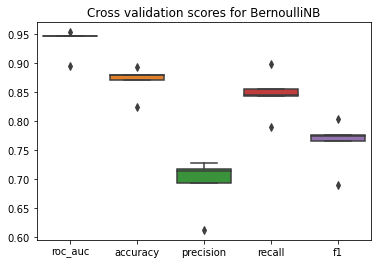

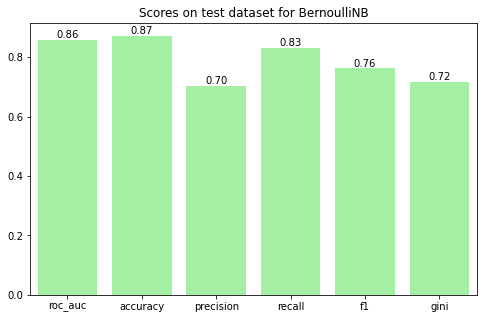

In [69]:
calculate_scores(X_train, X_test, y_train, y_test, model4)

### GradientBoostingClassifier

In [70]:
gbc = GradientBoostingClassifier(random_state=42)

params_grid = {"loss": ["log_loss", "exponential"],
               "criterion": ["friedman_mse", "squared_error"],
               "subsample": [0.8],
               "n_estimators": [100]}

model5 = optimize_params(gbc, params_grid, X_train, y_train)

GradientBoostingClassifier best recall_score: 0.965217, using: {'criterion': 'friedman_mse', 'loss': 'exponential', 'n_estimators': 100, 'subsample': 0.8}


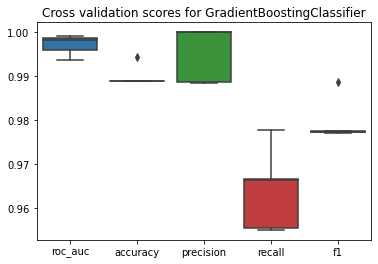

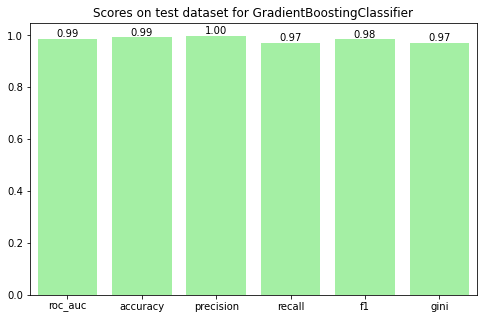

In [71]:
calculate_scores(X_train, X_test, y_train, y_test, model5)

### RandomForestClassifier

In [72]:
rfc = RandomForestClassifier(random_state=42)

params_grid = {"criterion": ["gini", "entropy", "log_loss"],
               "max_depth": np.arange(1, 9),
               "min_samples_leaf": np.arange(1, 6),
               "max_features": ["sqrt", "log2"],
               "ccp_alpha": [0, 0.05, 0.1]}

model6 = optimize_params(rfc, params_grid, X_train, y_train)

RandomForestClassifier best recall_score: 0.934783, using: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3}


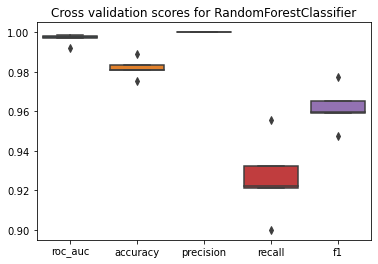

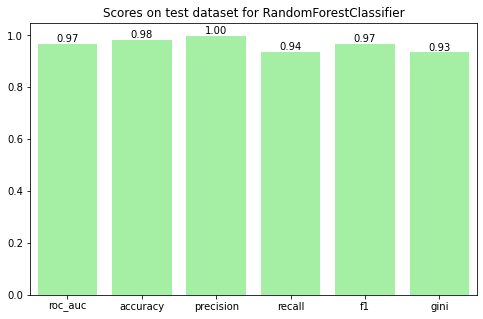

In [73]:
calculate_scores(X_train, X_test, y_train, y_test, model6)

### SVC

In [74]:
svc = SVC(random_state=42)

params_grid = {'C': [0.1, 1, 5, 10],
               'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               'gamma': ['scale', 'auto'],
               'degree': [2, 3, 4]}

model7 = optimize_params(svc, params_grid, X_train, y_train)

SVC best recall_score: 0.966304, using: {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}


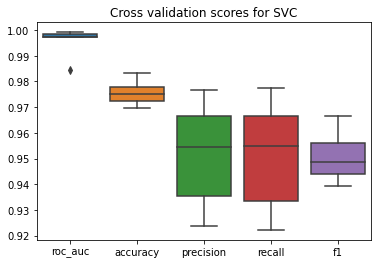

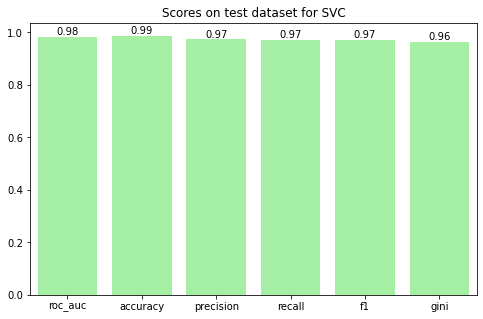

In [75]:
calculate_scores(X_train, X_test, y_train, y_test, model7)

### XGBoost

In [9]:
X_train_xg, X_test_xg = X_train.copy(), X_test.copy() 

X_train_xg.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_train.columns]
X_test_xg.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_test.columns]


In [10]:
xgb = XGBClassifier(random_state=42)

params_grid = param_grid = {'max_depth': np.arange(3, 11),
                            'subsample': [0.8],
                            'gamma': [0, 0.2, 0.5, 1],
                            'reg_alpha': [0, 0.5, 1],
                            'reg_lambda': [0, 0.5, 1]}

model8 = optimize_params(xgb, params_grid, X_train_xg, y_train)

XGBClassifier best recall_score: 0.976630, using: {'gamma': 1, 'max_depth': 4, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.8}


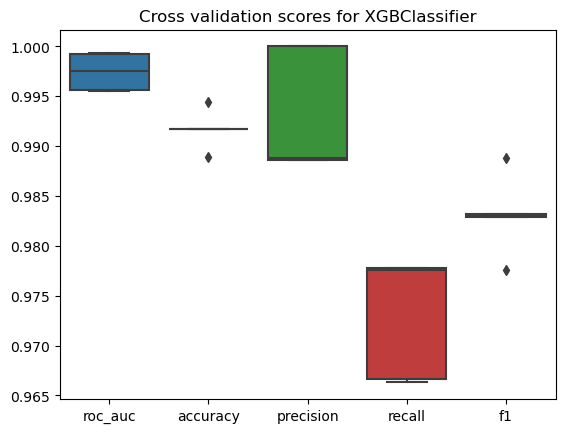

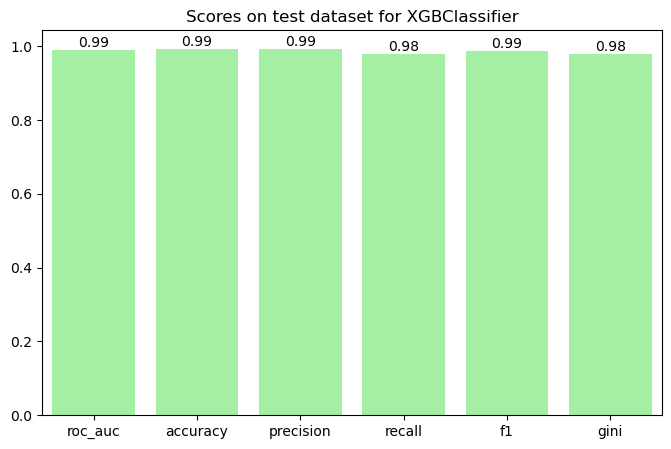

In [11]:
calculate_scores(X_train_xg, X_test_xg, y_train, y_test, model8)

### KNeighborsClassifier

In [79]:
knc = KNeighborsClassifier()

params_grid = {"n_neighbors": np.arange(2, 9),
                            "weights": ["uniform", "distance"],
                            "metric": ["cosine", "euclidean", "haversine", "manhattan", "minkowski"],
                            "leaf_size": np.arange(10, 51, 10)}

model9 = optimize_params(knc, params_grid, X_train, y_train)

/Users/julia/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julia/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/julia/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/julia/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/julia/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/julia/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", 

KNeighborsClassifier best recall_score: 0.916304, using: {'leaf_size': 10, 'metric': 'cosine', 'n_neighbors': 2, 'weights': 'distance'}


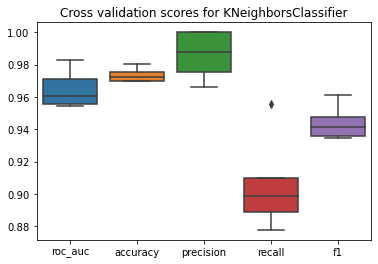

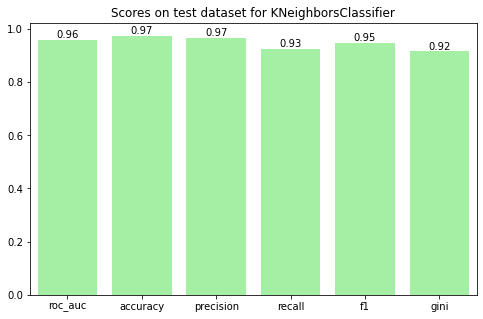

In [80]:
calculate_scores(X_train, X_test, y_train, y_test, model9)

### Pipeline

In [81]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [82]:
class MLPTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, **params):
        self.mlp = MLPClassifier(**params)
    
    def fit(self, X, y=None):
        self.mlp.fit(X, y)
        return self
    
    def transform(self, X):
        return self.mlp.predict_proba(X)
    
class CustomClassifierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classifier):
        self.classifier = classifier
    
    def fit(self, X, y=None):
        self.classifier.fit(X, y)
        return self
    
    def transform(self, X):
        return self.classifier.predict_proba(X)

In [83]:
mlp = MLPTransformer(alpha=0.001, learning_rate_init=0.001, random_state=42)

extra_trees = CustomClassifierTransformer(ExtraTreesClassifier(
    bootstrap=False,
    criterion='gini',
    max_features=0.6,
    min_samples_leaf=12,
    min_samples_split=3,
    n_estimators=100,
    random_state=42)
)

gaussianNB = GaussianNB()

In [84]:
pipeline = Pipeline([
    ('mlp', mlp),
    ('extra_trees', extra_trees),
    ('gaussian_nb', gaussianNB)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('mlp', MLPTransformer()),
                ('extra_trees',
                 CustomClassifierTransformer(classifier=ExtraTreesClassifier(max_features=0.6,
                                                                             min_samples_leaf=12,
                                                                             min_samples_split=3,
                                                                             random_state=42))),
                ('gaussian_nb', GaussianNB())])

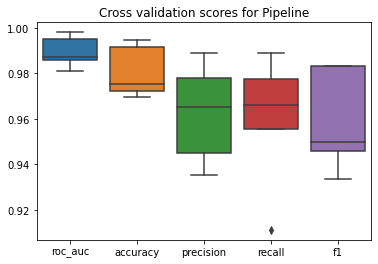

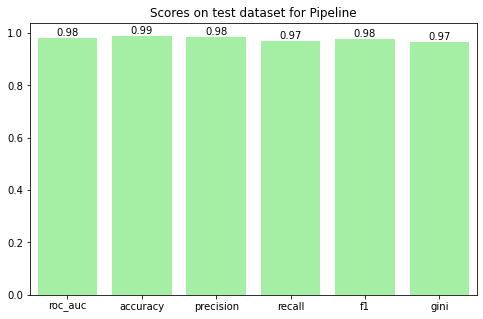

In [85]:
calculate_scores(X_train, X_test, y_train, y_test, pipeline)

## Model comparison

In [86]:
def compare_models(models, X_train, X_test, y_train, y_test):
    cross_val_scores = []
    model_names = []
    recall_scores = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for model in models:
        if model.__class__.__name__ == "XGBClassifier":
            
            X_train_xg, X_test_xg = X_train.copy(), X_test.copy() 
            X_train_xg.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_train.columns]
            X_test_xg.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_test.columns]
            
            cross_val_scores.append(cross_val_score(model, X_train_xg, y_train, cv=skf, scoring="recall"))
            y_predict = model.predict(X_test_xg)
        else:
            cross_val_scores.append(cross_val_score(model, X_train, y_train, cv=skf, scoring="recall"))
            y_predict = model.predict(X_test)
            
    
        model_names.append(model.__class__.__name__)
        recall_scores.append(recall_score(y_test, y_predict))
        
        
    sns.boxplot(data=cross_val_scores)
    plt.title("Cross validation recall scores comparision")
    plt.xticks(np.arange(0, len(model_names), 1), model_names, rotation=60)
    
    
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x= model_names, y=recall_scores, color='palegreen')
    plt.title('Recall scores on test dataset comparision')
    plt.xticks(rotation=60)
    
    for i, score in enumerate(recall_scores):
        ax.text(i, score, f'{score:.2f}', ha='center', va='bottom')
        
    plt.show()  
        

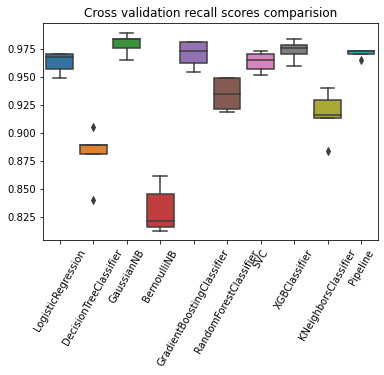

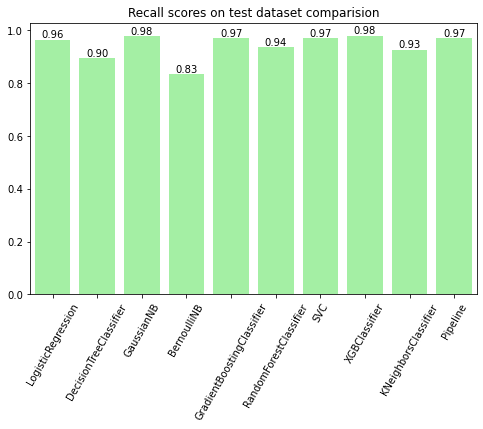

In [87]:
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, pipeline]
compare_models(models, X_train, X_test, y_train, y_test)

In [88]:
from sklearn import metrics 
def roc_curve_plot(models, X_val, y_val):
    plt.figure(0).clf()
    plt.figure(figsize=(8, 8))
    plt.title("ROC Curve for Different Models")
    for model in models:
        if model.__class__.__name__ == 'SVC':
            y_pred = model.decision_function(X_val)
        elif model.__class__.__name__ == 'XGBClassifier':
            X_val_xg = X_val.copy()
            X_val_xg.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_val.columns]
            y_pred = model.predict_proba(X_val_xg)[:, 1]
        else:
            y_pred = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_val, y_pred)
        auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
        model_name = model.__class__.__name__  
        plt.plot(fpr, tpr, label=f"{model_name}, AUC={auc}")
    plt.legend(framealpha=0.0)
    plt.savefig('plot.png', transparent=True)

<Figure size 432x288 with 0 Axes>

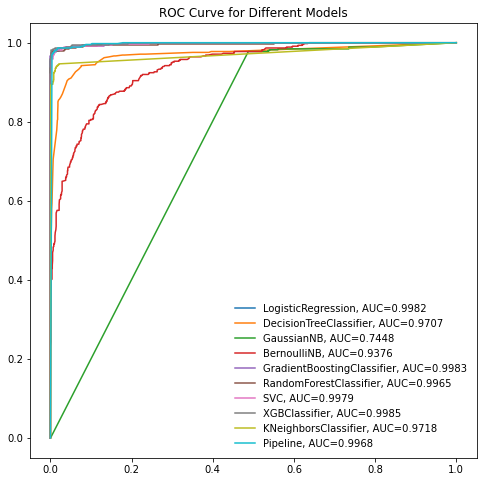

In [89]:
roc_curve_plot(models, X_test, y_test)

In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from tabulate import tabulate

def compare_models(models, X_train, X_test, y_train, y_test):
    results = []
    headers = ['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC', 'Gini']

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for model in models:
        if model.__class__.__name__ == "XGBClassifier":
            X_train_xg, X_test_xg = X_train.copy(), X_test.copy() 
            X_train_xg.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_train.columns]
            X_test_xg.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_test.columns]
            X_train_temp, X_test_temp = X_train_xg, X_test_xg
        else:
            X_train_temp, X_test_temp = X_train, X_test
        
        recall_scores = cross_val_score(model, X_train_temp, y_train, cv=skf, scoring="recall")
        accuracy_scores = cross_val_score(model, X_train_temp, y_train, cv=skf, scoring="accuracy")
        precision_scores = cross_val_score(model, X_train_temp, y_train, cv=skf, scoring="precision")
        f1_scores = cross_val_score(model, X_train_temp, y_train, cv=skf, scoring="f1")
        auc_scores = cross_val_score(model, X_train_temp, y_train, cv=skf, scoring="roc_auc")
        gini_scores = 2 * auc_scores - 1
        
        avg_recall = recall_scores.mean()
        avg_accuracy = accuracy_scores.mean()
        avg_precision = precision_scores.mean()
        avg_f1 = f1_scores.mean()
        avg_auc = auc_scores.mean()
        avg_gini = gini_scores.mean()
        
        results.append([model.__class__.__name__, avg_accuracy, avg_recall, avg_precision, avg_f1, avg_auc, avg_gini])

    print(tabulate(results, headers=headers, tablefmt='simple'))

compare_models(models, X_train, X_test, y_train, y_test)


Model                         Accuracy    Recall    Precision    F1 Score       AUC      Gini
--------------------------  ----------  --------  -----------  ----------  --------  --------
LogisticRegression            0.983421  0.9625       0.972002    0.967213  0.997842  0.995684
DecisionTreeClassifier        0.945839  0.880435     0.904996    0.892135  0.967191  0.934383
GaussianNB                    0.62545   0.979348     0.402707    0.57071   0.748597  0.497193
BernoulliNB                   0.863634  0.830978     0.694735    0.756229  0.932058  0.864116
GradientBoostingClassifier    0.989777  0.970109     0.989477    0.979667  0.997736  0.995472
RandomForestClassifier        0.983144  0.934239     0.999412    0.965686  0.997189  0.994377
SVC                           0.982869  0.963043     0.969363    0.966182  0.996626  0.993253
XGBClassifier                 0.990467  0.97337      0.989002    0.981089  0.998129  0.996257
KNeighborsClassifier          0.969329  0.916304     0.96133

Best models:
- XGBClassifier
- GradientBoostingClassifier
- Pipeline

We are choosing XGBClassifier as the best model.

## Shap

Shap plots for the best model - XGBClassifier (train data).

In [12]:
import shap
shap.initjs()

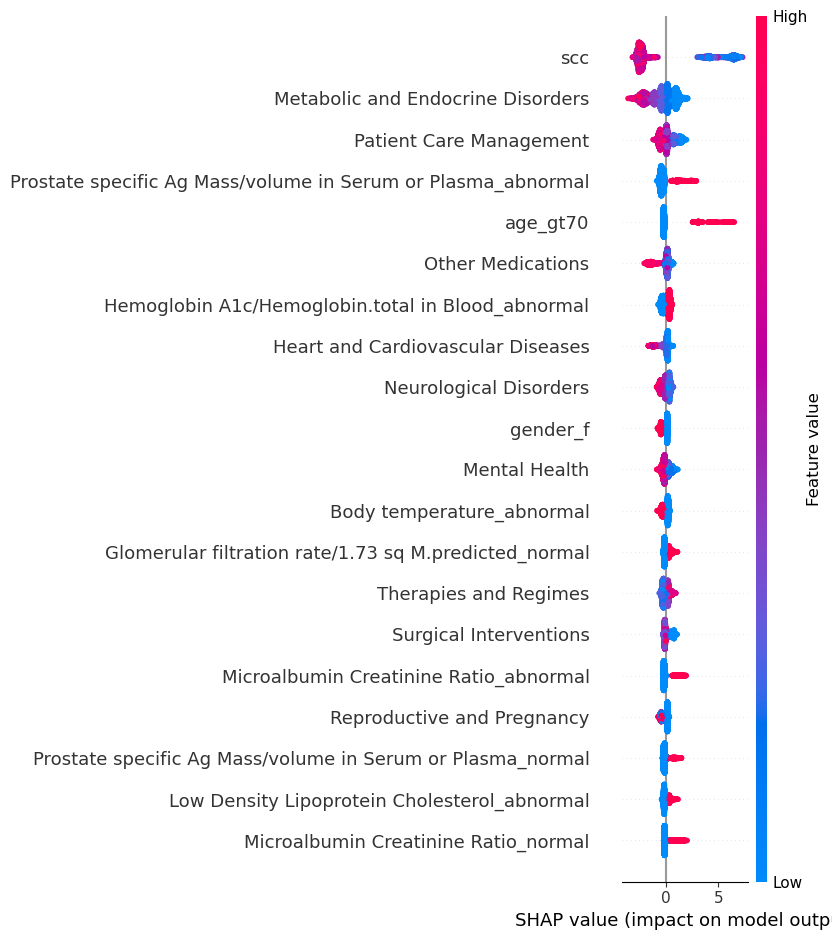

In [14]:
# Obliczanie wartości SHAP
explainer = shap.TreeExplainer(model8)
shap_values = explainer.shap_values(X_train_xg)

# Generowanie wykresu SHAP
shap.summary_plot(shap_values, X_train_xg)

Pierwsza obserwacja - przewidziana 1, w rzeczywistości jest 1.

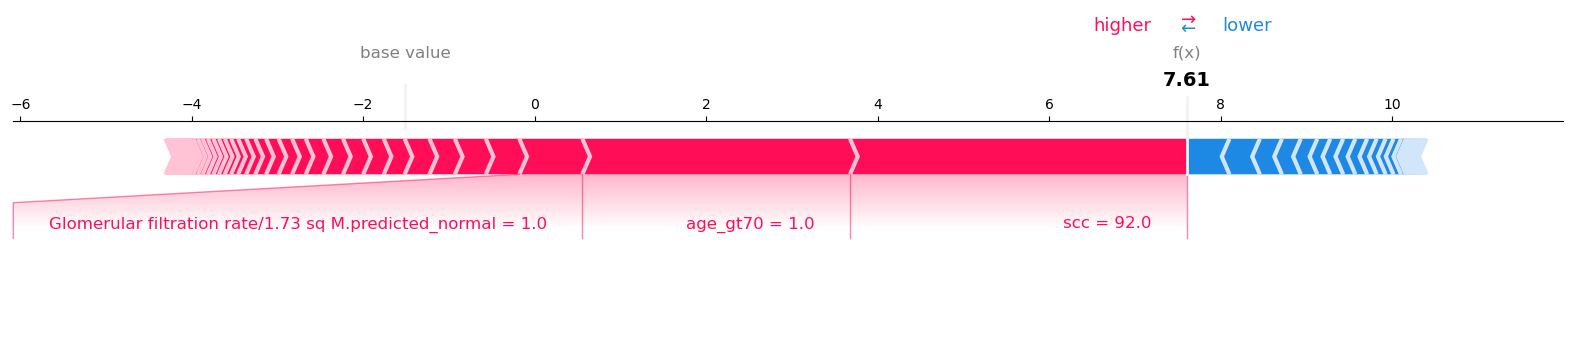

In [15]:
shap.force_plot(explainer.expected_value, shap_values[0], X_train_xg.iloc[0], matplotlib=True)

In [26]:
predicted_class = model8.predict(X_train_xg.iloc[[0]])[0]
predicted_class

1

In [24]:
actual_value = y_train.iloc[0]
actual_value

label    1
Name: 782, dtype: int64

Pierwsza obserwacja - przewidziana 0, w rzeczywistości jest 0.

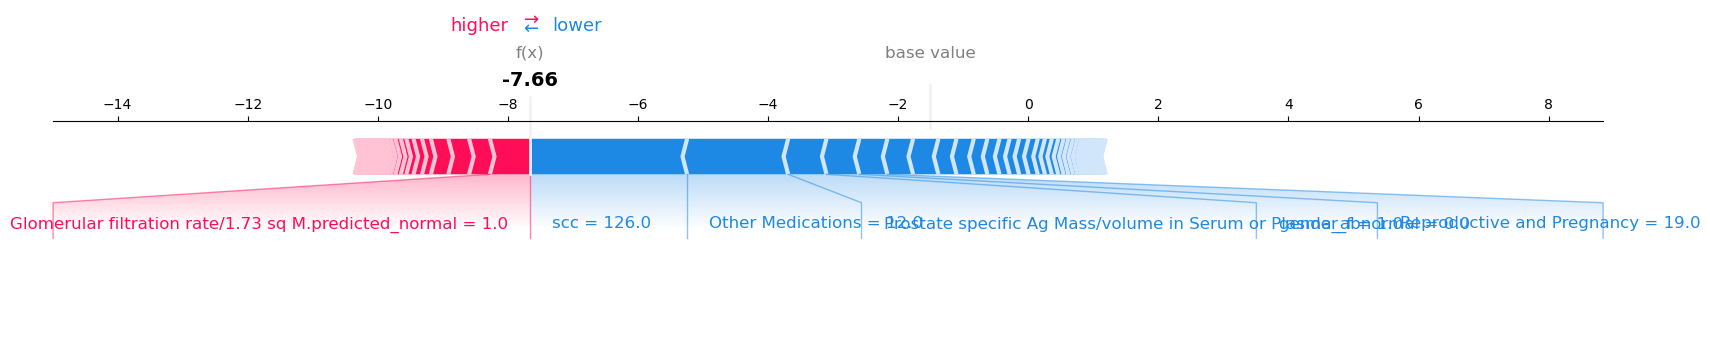

In [16]:
shap.force_plot(explainer.expected_value, shap_values[1], X_train_xg.iloc[1], matplotlib=True)

In [29]:
predicted_class = model8.predict(X_train_xg.iloc[[1]])[0]
predicted_class

0

In [27]:
actual_value = y_train.iloc[1]
actual_value

label    0
Name: 4198, dtype: int64

## Validation

In [92]:
X_val = pd.read_csv("../validation_data/X_val.csv")
y_val = pd.read_csv("../validation_data/y_val.csv")

In [93]:
X_val.shape[1] == X_train.shape[1]

True

In [129]:
best_model = [model8]

<Figure size 432x288 with 0 Axes>

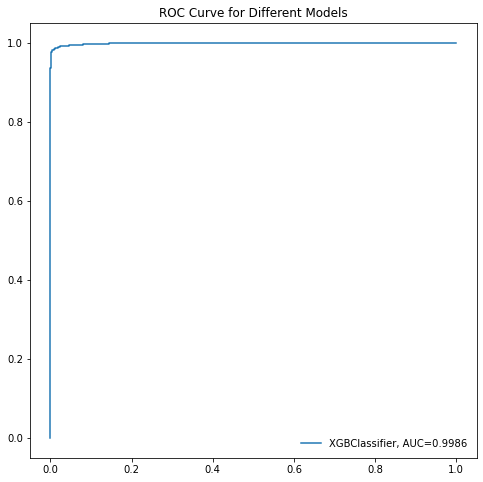

In [130]:
roc_curve_plot(best_model, X_val, y_val)

In [131]:
def calculate_metrics(model, X_val, y_val):
    if model.__class__.__name__ == 'XGBClassifier':
        X_val_xg = X_val.copy()
        X_val_xg.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_val.columns]
        predictions = model.predict(X_val_xg)
        auc = roc_auc_score(y_val, model.predict_proba(X_val_xg)[:, 1])
    else:
        predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    if model.__class__.__name__ == 'SVC':
        auc = roc_auc_score(y_val, model.decision_function(X_val))
    elif model.__class__.__name__ != 'XGBClassifier':
        auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    gini = 2 * auc - 1
    return accuracy, recall, precision, f1, auc, gini

def print_metrics(models,  X_val, y_val):
    results = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC', 'Gini'])
    for model in models:
        accuracy, recall, precision, f1, auc, gini = calculate_metrics(model,  X_val, y_val)
        results.loc[len(results)] = {'Model': model.__class__.__name__,
                                        'Accuracy': accuracy,
                                        'Recall': recall,
                                        'Precision': precision,
                                        'F1 Score': f1,
                                        'AUC': auc,
                                        'Gini': gini}
    print(tabulate(results, headers='keys', tablefmt='simple'))

In [133]:
print_metrics(best_model, X_val, y_val)

    Model            Accuracy    Recall    Precision    F1 Score       AUC      Gini
--  -------------  ----------  --------  -----------  ----------  --------  --------
 0  XGBClassifier    0.991493  0.977733     0.988741    0.983206  0.998599  0.997198
